In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from IPython.display import display
from pathlib import Path
import wandb
from kaggle_secrets import UserSecretsClient

import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
wandb.login(key=UserSecretsClient().get_secret("wan_db"))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Metric:

Recall

In [3]:
train_dir = '../input/construction-machinery-cls/train_dataset_train/train'
test_dir = '../input/construction-machinery-cls/test_dataset_test/test'
test = pd.read_csv('../input/construction-machinery-cls/test_dataset_test/test.csv')
train = pd.read_csv('../input/construction-machinery-cls/train_dataset_train/train.csv')
train['class'] = train['class'].astype(int)

In [4]:
test.head(5)

,ID_img,class
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [5]:
train.head(5)

,ID_img,class
0,2138.jpg,4
1,2139.jpg,6
2,2140.jpg,3
3,2141.jpg,6
4,2142.jpg,3


In [6]:
train['class'].value_counts()

1    1586
3     969
4     797
5     514
0     321
2     316
6     293
7     194
Name: class, dtype: int64

In [7]:
len(train['class'].unique())

8

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(train['ID_img'], train['class'], test_size=0.2, random_state=42, stratify=train['class'])

In [9]:
train['path'] = train['ID_img'].apply(lambda x: f'{train_dir}/{x}')
test['path'] = test['ID_img'].apply(lambda x: f'{test_dir}/{x}')

In [10]:
Image.open(train['path'].iloc[5]).size

(128, 112)

In [11]:
import datasets

features = datasets.Features({
    'image': datasets.Image(),
    'label': datasets.Value('int32')
})

dataset_dict = {
    'image': train['path'].values,
    'label': train['class'].values
}

dataset = datasets.Dataset.from_dict(dataset_dict, features)

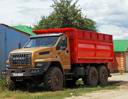

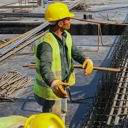

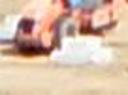

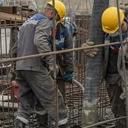

In [12]:
display(dataset[0]['image'], dataset[2]['image'], dataset[3]['image'], dataset[4]['image'])

In [13]:
features = datasets.Features({
    'image': datasets.Image(),
    'label': datasets.Value('int32')
})

dataset_dict = {
    'image': test['path'].values,
    'label': test['class'].values
}

test_dataset = datasets.Dataset.from_dict(dataset_dict, features)
test = test.drop(columns=['path'])

In [14]:
dataset = dataset.train_test_split(test_size=0.1,)
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x98>,
 'label': 7}

Preprocess

In [15]:
from transformers import AutoFeatureExtractor

feature_extractor_beit = AutoFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")
feature_extractor_vit = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [16]:
feature_extractor_beit

BeitFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": false,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 224
}

In [17]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor # REPLACE to resize

normalize = Normalize(mean=feature_extractor_beit.image_mean, std=feature_extractor_beit.image_std)
_transforms = Compose([RandomResizedCrop(feature_extractor_beit.size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [18]:
dataset = dataset.with_transform(transforms)
test_dataset = test_dataset.with_transform(transforms)

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

Train

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model_beit = AutoModelForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224",
    num_labels=len(train['class'].value_counts()),
    ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/68.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir="./results_beit",
    per_device_train_batch_size=32, # 16
    evaluation_strategy="steps",
    num_train_epochs=90, # 40
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model_beit,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor_beit,
)

trainer.train()

Using cuda_amp half precision backend
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4491
  Num Epochs = 90
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6390
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: dimka11. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
100,0.311800,0.215922
200,0.205200,0.278627
300,0.193200,0.267804
400,0.161200,0.209906
500,0.162100,0.222107
600,0.169700,0.206275
700,0.147500,0.174198
800,0.099600,0.242779
900,0.130200,0.166009
1000,0.159500,0.253749


***** Running Evaluation *****
  Num examples = 499
  Batch size = 16
Saving model checkpoint to ./results_beit/checkpoint-100
Configuration saved in ./results_beit/checkpoint-100/config.json
Model weights saved in ./results_beit/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results_beit/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 499
  Batch size = 16
Saving model checkpoint to ./results_beit/checkpoint-200
Configuration saved in ./results_beit/checkpoint-200/config.json
Model weights saved in ./results_beit/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results_beit/checkpoint-200/preprocessor_config.json
/opt/conda/lib/python3.7/site-package

TrainOutput(global_step=6390, training_loss=0.08427278091533456, metrics={'train_runtime': 5013.1085, 'train_samples_per_second': 80.627, 'train_steps_per_second': 1.275, 'total_flos': 3.1309784462171013e+19, 'train_loss': 0.08427278091533456, 'epoch': 90.0})

In [21]:
Path("./weights").mkdir(parents=True, exist_ok=True)

In [22]:
model_beit.save_pretrained('./weights/beit-base-patch16-224_fine_tuned')
feature_extractor_beit.save_pretrained('./weights/beit-base-patch16-224_feature_extractor')

Configuration saved in ./weights/beit-base-patch16-224_fine_tuned/config.json
Model weights saved in ./weights/beit-base-patch16-224_fine_tuned/pytorch_model.bin
Feature extractor saved in ./weights/beit-base-patch16-224_feature_extractor/preprocessor_config.json


['./weights/beit-base-patch16-224_feature_extractor/preprocessor_config.json']

In [23]:
# load
# from transformers import BeitFeatureExtractor, BeitModel, BeitConfig
# import torch

# feature_extractor = BeitFeatureExtractor.from_pretrained("./weights/beit-base-patch16-224_feature_extractor")
# model = BeitModel.from_pretrained("./weights/beit-base-patch16-224_fine_tuned")

eval

In [24]:
preds = trainer.predict(dataset['test'])
preds.predictions.shape, preds.label_ids.shape

***** Running Prediction *****
  Num examples = 499
  Batch size = 16


((499, 8), (499,))

In [25]:
accuracy_score(preds.label_ids, np.argmax(preds.predictions, axis=1))

0.9819639278557114

In [26]:
f1_score(preds.label_ids, np.argmax(preds.predictions, axis=1), average='macro')

0.9766842864081382

<AxesSubplot:>

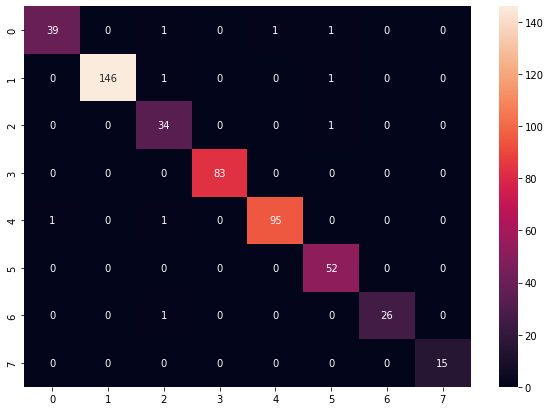

In [27]:
cm = confusion_matrix(preds.label_ids, np.argmax(preds.predictions, axis=1))

df_cm = pd.DataFrame(cm, index = [i for i in "01234567"],
                  columns = [i for i in "01234567"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

In [28]:
recall_score(preds.label_ids, np.argmax(preds.predictions, axis=1), average='macro')

0.9786038615935524

Predict test

In [29]:
preds_test = trainer.predict(test_dataset)
np.save('./beit_preds.npy', preds_test)
test['class'] = np.argmax(preds_test.predictions, axis=1)
test.to_csv('beit_90epoch.csv', index=False)

***** Running Prediction *****
  Num examples = 2138
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


ViT

In [30]:
model_vit = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(train['class'].value_counts()),
    ignore_mismatched_sizes=True)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-12

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

storing https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/d01bfc4a52063e6f2cc1bc7063192e012043a7c6d8e75981bb6afbb9dc911001.e4710baf72bd00d091aab2ae692d487c057734cf044ba421696823447b95521e
creating metadata file for /root/.cache/huggingface/transformers/d01bfc4a52063e6f2cc1bc7063192e012043a7c6d8e75981bb6afbb9dc911001.e4710baf72bd00d091aab2ae692d487c057734cf044ba421696823447b95521e
loading weights file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/d01bfc4a52063e6f2cc1bc7063192e012043a7c6d8e75981bb6afbb9dc911001.e4710baf72bd00d091aab2ae692d487c057734cf044ba421696823447b95521e
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassi

In [31]:
training_args = TrainingArguments(
    output_dir="./results_vit",
    per_device_train_batch_size=32, # 16
    evaluation_strategy="steps",
    num_train_epochs=90, # 40
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model_vit,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor_vit,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4491
  Num Epochs = 90
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6390
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss
100,0.251400,0.229973
200,0.182800,0.254821
300,0.169300,0.198655
400,0.138200,0.192920
500,0.144800,0.157877
600,0.134800,0.145515
700,0.118000,0.177622
800,0.074900,0.132548
900,0.074100,0.143462
1000,0.115900,0.162061


***** Running Evaluation *****
  Num examples = 499
  Batch size = 16
Saving model checkpoint to ./results_vit/checkpoint-100
Configuration saved in ./results_vit/checkpoint-100/config.json
Model weights saved in ./results_vit/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results_vit/checkpoint-100/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 499
  Batch size = 16
Saving model checkpoint to ./results_vit/checkpoint-200
Configuration saved in ./results_vit/checkpoint-200/config.json
Model weights saved in ./results_vit/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results_vit/checkpoint-200/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/

TrainOutput(global_step=6390, training_loss=0.06015912367028063, metrics={'train_runtime': 4617.8186, 'train_samples_per_second': 87.528, 'train_steps_per_second': 1.384, 'total_flos': 3.1323171629822607e+19, 'train_loss': 0.06015912367028063, 'epoch': 90.0})

In [32]:
preds = trainer.predict(dataset['test'])
preds.predictions.shape, preds.label_ids.shape

***** Running Prediction *****
  Num examples = 499
  Batch size = 16


((499, 8), (499,))

In [33]:
recall_score(preds.label_ids, np.argmax(preds.predictions, axis=1), average='macro')

0.9868390113235475

In [34]:
model_vit.save_pretrained('./weights/vit-base-patch16-224-in21k_fine_tuned')
feature_extractor_vit.save_pretrained('./weights/vit-base-patch16-224-in21k_feature_extractor')

Configuration saved in ./weights/vit-base-patch16-224-in21k_fine_tuned/config.json
Model weights saved in ./weights/vit-base-patch16-224-in21k_fine_tuned/pytorch_model.bin
Feature extractor saved in ./weights/vit-base-patch16-224-in21k_feature_extractor/preprocessor_config.json


['./weights/vit-base-patch16-224-in21k_feature_extractor/preprocessor_config.json']

In [35]:
preds_test = trainer.predict(test_dataset)
np.save('./vit_preds.npy', preds_test)
test['class'] = np.argmax(preds_test.predictions, axis=1)
test.to_csv('vit_90epoch.csv', index=False)

***** Running Prediction *****
  Num examples = 2138
  Batch size = 16
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
